## Tra loi cau hoi

###
   Q1: Phep toan nao sau day khong thuoc lop tich chap (Convolutional layer)?
   a. Convolutional b. stride c.padding d.max pooling  
   -> choose D
###

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torchsummary as summary
from PIL import Image

# set the seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# download the MNIST dataset
ROOT = './data'
train_data = datasets.MNIST(root=ROOT, train=True, download=True)
test_data = datasets.MNIST(root=ROOT, train=False, download=True)



In [2]:
train_data.data.shape
test_data.data.shape
train_data.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [3]:
# split the training data into training and validation sets
RATIO = 0.9

n_train_examples = int(len(train_data) * RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

# compute mean and standard deviation of the training data
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

# define the transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])
valid_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = valid_transforms


In [4]:
#Create dataloader
BATCH_SIZE = 256

train_dataloader = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, )
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

In [5]:
len(train_dataloader)

211

In [6]:
next(iter(train_dataloader))[0].shape

torch.Size([256, 1, 28, 28])

# Create LeNet

In [7]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
    
    def forward(self, x):
        outputs = self.conv1(x)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        outputs = self.fc3(outputs)

        return outputs

# train model

In [8]:
import time 

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        #compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        #backwards pass
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                '| epoch {:3d} | {:5d}/{:5d} batches '
                '| train_accuracy {:8.3f}'.format(epoch, idx, len(train_dataloader), total_acc/total_count)
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss
    
def evaluation(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
        
    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)

    return epoch_acc, epoch_loss

In [14]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LeNetClassifier(num_classes=num_classes).to(device)

print(f"Model structure: {model}\n\n")

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

num_epoch = 10
save_dir = './model'
os.makedirs(save_dir, exist_ok=True)

train_accs, train_losses = [], []
valid_accs, valid_losses = [], []
best_loss_val = 100

for epoch in range(1, num_epoch+1):
    epoch_start_time = time.time()

    #training
    train_acc, train_loss = train(model, optimizer, criterion, train_dataloader, device)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    #validation
    valid_acc, valid_loss = evaluation(model, criterion, valid_dataloader, device)
    valid_accs.append(valid_acc)
    valid_losses.append(valid_loss)

    #save the model with the best validation loss
    if valid_loss < best_loss_val:
        best_loss_val = valid_loss
        torch.save(model.state_dict(), save_dir + '/best_model.pt')

    #print the summary
    print('-' * 89)
    print(
        '| end of epoch {:3d} | time: {:5.2f}s '
        '| valid accuracy {:8.3f} | valid loss {:8.3f}'.format(
            epoch, time.time() - epoch_start_time, valid_acc, valid_loss
        )
    )

    #load best model
    model.load_state_dict(torch.load(save_dir + '/best_model.pt'))
    model.eval()


Model structure: LeNetClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


| epoch   0 |    50/  211 batches | train_accuracy    0.706
| epoch   0 |   100/  211 batches | train_accuracy    0.910
| epoch   0 |   150/  211 batches | train_accuracy    0.930
| epoch   0 |   200/  211 batches | train_accuracy    0.950
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 14.37s | valid accuracy    0.950 | valid loss    0.157


C:\Users\hoang\AppData\Local\Temp\ipykernel_20348\3457812595.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_dir + '/best_model.pt

| epoch   0 |    50/  211 batches | train_accuracy    0.958
| epoch   0 |   100/  211 batches | train_accuracy    0.963
| epoch   0 |   150/  211 batches | train_accuracy    0.970
| epoch   0 |   200/  211 batches | train_accuracy    0.965
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 14.04s | valid accuracy    0.970 | valid loss    0.096
| epoch   0 |    50/  211 batches | train_accuracy    0.973
| epoch   0 |   100/  211 batches | train_accuracy    0.976
| epoch   0 |   150/  211 batches | train_accuracy    0.971
| epoch   0 |   200/  211 batches | train_accuracy    0.975
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 12.65s | valid accuracy    0.974 | valid loss    0.086
| epoch   0 |    50/  211 batches | train_accuracy    0.978
| epoch   0 |   100/  211 batches | train_accuracy    0.977
| epoch   0 |   150/  211 batches | train_accuracy    0.

In [12]:
test_data.transform = valid_transforms
test_data_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
test_acc, test_loss = evaluation(model, criterion, test_data_loader, device)
test_acc, test_loss

(0.9834, np.float64(0.0502489468010026))

# Plot result

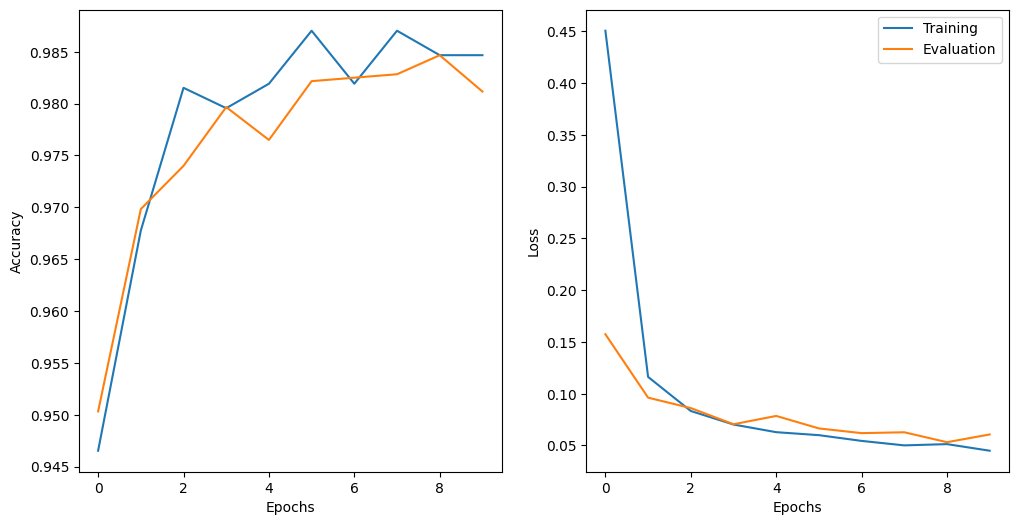

In [15]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epoch, train_accs, valid_accs, train_losses, valid_losses)